In [47]:
import sys
sys.path.insert(1, "../")

import importlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [48]:
def reload_modules():
    import ghost_unfairness
    importlib.reload(ghost_unfairness.fair_dataset)
    importlib.reload(ghost_unfairness.utils)
    
reload_modules()

from ghost_unfairness.fair_dataset import FairDataset, default_mappings

from ghost_unfairness.utils import *

In [49]:
protected = ["sex"]
privileged_classes = [['Male']]
metadata = default_mappings.copy()
metadata['protected_attribute_maps'] = [{1.0: 'Male', 0.0: 'Female'}]

alpha = 0.5
beta = 1

kwargs = {'protected_attribute_names': protected,
          'privileged_classes': [['Male']],
          'metadata':metadata,
          'favorable_classes': [1],
          'beta': beta,
          'alpha': alpha
         }

random_state = 47
model_type = GaussianNB

In [ ]:
from copy import deepcopy
dist = {
    'mu_ps': {'p': 3, 'u': 0},
    'sigma_ps': {'p': 2, 'u': 5},
    'mu_ns': {'p': 3, 'u': 0},
    'sigma_ns': {'p': 2, 'u': 5},
}

results = {'p' : [], 'u': [], 'm': []}
deltas = []
start = 1
end = 20
for i in range(start, end):
    temp_dist = deepcopy(dist)
    mu_ps = temp_dist['mu_ps']
    for k in mu_ps:
        mu_ps[k] = mu_ps[k] + i
    kwargs['dist'] = temp_dist
    print(kwargs['dist'])    
    
    kwargs['verbose'] = False
    train_fd, test_fd = get_datasets(10000, 2, 1, kwargs, test_random_state=23)
    pmod, pmod_results = get_groupwise_performance(train_fd, train_fd, model_type,
                                                   privileged=True, pos_rate=True)
    umod, umod_results = get_groupwise_performance(train_fd, train_fd, model_type,
                                                   privileged=False, pos_rate=True)
    mod, mod_results = get_groupwise_performance(train_fd, train_fd, model_type,
                                                 privileged=None, pos_rate=True)
    
    # is_u_optimal = umod_results[4] >= pmod_results[4] and umod_results[4] >= mod_results[4] 
    is_u_optimal = umod_results[4] > pmod_results[4]
    # is_p_optimal = pmod_results[3] >= umod_results[3] and pmod_results[3] >= mod_results[3]
    is_p_optimal = pmod_results[3] > umod_results[3]
    is_m_optimal = mod_results[2] > umod_results[2] and mod_results[2] > pmod_results[2]
    
    opt_diff = is_u_optimal and is_p_optimal and is_m_optimal
    
    violates = mod_results[1] > umod_results[1] and mod_results[1] > pmod_results[1]
    
    kwargs['verbose'] = True
    if kwargs['verbose']:
        print(opt_diff)
    
        print('Violates', opt_diff and violates)
    
        print('pmod_results', *pmod_results, sep='\t')
        print('umod_results', *umod_results, sep='\t')
        print('mod_results', *mod_results, sep='\t')
    assert not (opt_diff and violates)
    
    # if opt_diff and not violates:
    results['p'].append(pmod_results)
    results['u'].append(umod_results)
    results['m'].append(mod_results)

    # print(kwargs)

In [ ]:
plt.plot(range(start, end), [i[1] for i in results['p']], '*-', label='p')
plt.plot(range(start, end), [i[1] for i in results['u']], '*-', label='u')
plt.plot(range(start, end), [i[1] for i in results['m']], '*-', label='m')
plt.legend()

In [ ]:
c_by_ds = []
di_diffs = []
for i in range(0, end - start):
    pmod_res = results['p'][i]
    umod_res = results['u'][i]
    mod_res = results['m'][i]
    di_u = umod_res[1]
    di = mod_res[1]
    acc_diff_u =  umod_res[4] - mod_res[4]
    acc_diff_p = pmod_res[3] - mod_res[3]
    print(acc_diff_u, acc_diff_p)
    del_p_plus = pmod_res[5] - mod_res[5] 
    del_p_minus = pmod_res[6] - mod_res[6]

    del_u_plus = umod_res[7] - mod_res[7]
    del_u_minus = umod_res[8] - mod_res[8]
    print(del_p_plus, del_p_minus, del_u_plus, del_u_minus)
    c = acc_diff_u + 2 * (1-alpha) * del_u_minus
    d = acc_diff_p + 2 * (1-alpha) * del_p_minus
    if d == 0:
        break
    c_by_ds.append(c/d)
    di_diffs.append(di_u - di)
    if c > d:
        assert di < di_u
        
print(*list(zip(c_by_ds, di_diffs)),sep='\n')

plt.plot(-np.log(np.abs(c_by_ds)), di_diffs, '*-')

In [ ]:
acc_diff_u = [(i[0][4] - i[1][4]) for i in zip(results['u'], results['m'])]
acc_diff_u
acc_diff_p = [(i[0][3] - i[1][3]) for i in zip(results['p'], results['m'])]
acc_diff_p
di_diff = [i[0][1] - i[1][1] for i in zip(results['u'], results['m'])]
di_diff

In [ ]:
#plt.plot(range(-10, n), [i[3] for i in results['p']], '*-', label='p')
plt.plot(range(start, end), [abs(i[3] - i[4]) for i in results['u']], '*-', label='u')
#plt.plot(range(-10, n), [i[2] for i in results['m']], '*-', label='m')
plt.legend()

In [ ]:
dist = {
    'mu_ps': {'p': 13, 'u': 10},
    'sigma_ps': {'p': 2, 'u': 5},
    'mu_ns': {'p': 3, 'u': 0},
    'sigma_ns': {'p': 2, 'u': 5},
}

model_results = {'p': [], 'u': [], 'm': []}
kwargs['dist'] = dist
model_types = [GaussianNB, LogisticRegression, DecisionTreeClassifier]
for model_type in model_types:
    
    kwargs['verbose'] = False
    train_fd, test_fd = get_datasets(10000, 10, 3, kwargs, test_random_state=47)
    pmod, pmod_results = get_groupwise_performance(train_fd, train_fd, model_type,
                                                   privileged=True, pos_rate=True)
    umod, umod_results = get_groupwise_performance(train_fd, train_fd, model_type,
                                                   privileged=False, pos_rate=True)
    mod, mod_results = get_groupwise_performance(train_fd, train_fd, model_type,
                                                 privileged=None, pos_rate=True)
    
    kwargs['verbose'] = True
    if kwargs['verbose']:
        print(opt_diff)
    
        print('Violates', opt_diff and violates)
    
        print('pmod_results', *pmod_results, sep='\t')
        print('umod_results', *umod_results, sep='\t')
        print('mod_results', *mod_results, sep='\t')
    model_results['p'].append(pmod_results)
    model_results['u'].append(umod_results)
    model_results['m'].append(mod_results)


In [ ]:
dist

In [ ]:
plt.bar(range(0, len(model_types)*2, 2), [i[1] for i in model_results['u']], label='u')
plt.bar(range(1, len(model_types)*2, 2), [i[1] for i in model_results['m']], label= 'm')
plt.ylim(0.9, 1.1)
plt.legend()

In [18]:
from copy import deepcopy
dist = {
    'mu_ps': {'p': 13, 'u': 10},
    'sigma_ps': {'p': 2, 'u': 5},
    'mu_ns': {'p': 3, 'u': 0},
    'sigma_ns': {'p': 2, 'u': 5},
}

results = {'p' : [], 'u': [], 'm': []}
start = 0
end = 10
for i in range(start, end):
    temp_dist = deepcopy(dist)
    sigma_ps = temp_dist['sigma_ps']
    sigma_ns = temp_dist['sigma_ns']
    sigma_ps['u'] = sigma_ps['u'] + i
    sigma_ns['u'] = sigma_ns['u'] + i

    print(temp_dist)    
    kwargs['dist'] = temp_dist
    kwargs['verbose'] = False
    
    train_fd, test_fd = get_datasets(10000, 2, 1, kwargs, test_random_state=47)
    pmod, pmod_results = get_groupwise_performance(train_fd, train_fd, model_type,
                                                   privileged=True, pos_rate=True)
    umod, umod_results = get_groupwise_performance(train_fd, train_fd, model_type,
                                                   privileged=False, pos_rate=True)
    mod, mod_results = get_groupwise_performance(train_fd, train_fd, model_type,
                                                 privileged=None, pos_rate=True)
    
    results['p'].append(pmod_results)
    results['u'].append(umod_results)
    results['m'].append(mod_results)

    # print(kwargs)

{'mu_ps': {'p': 13, 'u': 10}, 'sigma_ps': {'p': 2, 'u': 5}, 'mu_ns': {'p': 3, 'u': 0}, 'sigma_ns': {'p': 2, 'u': 5}}
{'mu_ps': {'p': 13, 'u': 10}, 'sigma_ps': {'p': 2, 'u': 6}, 'mu_ns': {'p': 3, 'u': 0}, 'sigma_ns': {'p': 2, 'u': 6}}
{'mu_ps': {'p': 13, 'u': 10}, 'sigma_ps': {'p': 2, 'u': 7}, 'mu_ns': {'p': 3, 'u': 0}, 'sigma_ns': {'p': 2, 'u': 7}}


KeyboardInterrupt: 

In [ ]:
plt.plot(range(start, end), [i[1] for i in results['u']], '*-', label='u')
plt.plot(range(start, end), [i[1] for i in results['m']], '*-', label='m')
plt.legend()

In [ ]:
#plt.plot(range(-10, n), [i[3] for i in results['p']], '*-', label='p')
plt.plot(range(start, end), [abs(i[3] - i[4]) for i in results['u']], '*-', label='p-u')
#plt.plot(range(-10, n), [i[2] for i in results['m']], '*-', label='m')
plt.legend()

In [58]:
dist = {
    'mu_ps': {'p': 10, 'u': 4},
    'sigma_ps': {'p': 2, 'u': 5},
    'mu_ns': {'p': 0, 'u': 2},
    'sigma_ns': {'p': 2, 'u': 5},
}

results = {'p' : [], 'u': [], 'm': []}
temp_dist = deepcopy(dist)
kwargs['dist'] = temp_dist
print(kwargs['dist'])   
model_type = GaussianNB

for alpha in [0.25, 0.5, 0.75]:
    print('alpha', alpha)
    kwargs['alpha'] = alpha
    kwargs['verbose'] = False
    train_fd, test_fd = get_datasets(10000, 0, 1, kwargs, test_random_state=23)
    pmod, pmod_results = get_groupwise_performance(train_fd, test_fd, model_type,
                                                   privileged=True, pos_rate=True)
    umod, umod_results = get_groupwise_performance(train_fd, test_fd, model_type,
                                                   privileged=False, pos_rate=True)
    mod, mod_results = get_groupwise_performance(train_fd, test_fd, model_type,
                                                 privileged=None, pos_rate=True)
    if kwargs['verbose']:
        print('Theta')
        print(pmod.theta_)
        print(umod.theta_)
        print(mod.theta_)

        print('Sigma')
        print(pmod.sigma_)
        print(umod.sigma_)
        print(mod.sigma_)
    
    is_u_optimal = umod_results[4] > pmod_results[4]
    is_p_optimal = pmod_results[3] > umod_results[3]
    is_m_optimal = mod_results[2] > umod_results[2] and mod_results[2] > pmod_results[2]

    opt_diff = is_u_optimal and is_p_optimal and is_m_optimal

    violates = mod_results[1] > umod_results[1] and mod_results[1] > pmod_results[1]

    # print(opt_diff)

    # print('Violates', opt_diff and violates)

    
    print('pmod_results', *['{:.4f}'.format(i) for i in pmod_results], sep='\t')
    print('umod_results', *['{:.4f}'.format(i) for i in umod_results], sep='\t')
    print('mod_results', *['{:.4f}'.format(i) for i in mod_results], sep='\t')


{'mu_ps': {'p': 10, 'u': 4}, 'sigma_ps': {'p': 2, 'u': 5}, 'mu_ns': {'p': 0, 'u': 2}, 'sigma_ns': {'p': 2, 'u': 5}}
alpha 0.25
pmod_results	0.0542	1.2153	0.2153	0.8247	0.9954	0.6540	0.9944	0.0043	0.4200	0.2680
umod_results	0.1662	1.5149	0.5149	0.7475	0.9272	0.5678	1.0000	0.0971	0.6136	0.4475
mod_results	0.0976	1.3745	0.3745	0.8122	0.9894	0.6350	1.0000	0.0141	0.4864	0.3155
alpha 0.5
pmod_results	-0.1576	0.6842	0.3158	0.7838	0.9950	0.5726	0.9940	0.0040	0.4140	0.2688
umod_results	-0.0206	0.9623	0.0377	0.7661	0.9534	0.5788	1.0000	0.0932	0.6048	0.4472
mod_results	-0.1070	0.7885	0.2115	0.7857	0.9926	0.5788	0.9984	0.0132	0.4776	0.3200
alpha 0.75
pmod_results	-0.3686	0.5058	0.4942	0.7449	0.9938	0.4960	0.9931	0.0040	0.4155	0.2624
umod_results	-0.2212	0.7138	0.2862	0.7836	0.9770	0.5902	1.0000	0.0920	0.5947	0.4232
mod_results	-0.3156	0.5801	0.4199	0.7626	0.9956	0.5296	0.9981	0.0120	0.4771	0.3128


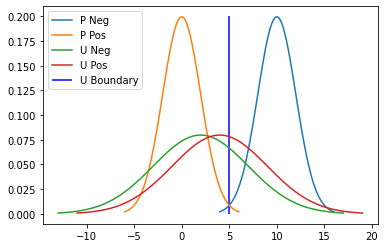

In [60]:
plot_normal(10, 2, label='P Neg')
plot_normal(0, 2, label='P Pos')
# plt.vlines(5, 0, 0.2, label = 'P Boundary', color='red')
plot_normal(2, 5, label='U Neg')
plot_normal(4, 5, label='U Pos')
plt.vlines(5, 0, 0.2, label = 'U Boundary', color='blue')
# plot_non_linear_boundary(, mu2, sigma1, sigma2, p, d, label=None)
# plot_normal(1.5, 4.09, label='Pos')
# plot_normal(11.5, 4.09, label='Neg')
# plt.vlines(4, 0, 0.2, label='Boundary', color='orange')
# plt.xlim(-25, 35)
# plt.ylim(-0.005, 0.205)
plt.legend()

In [ ]:
test_fd_x, test_fd_y = test_fd.get_xy(keep_protected=False)
print(np.unique(test_fd_y, return_counts=True)), 
np.unique(umod.predict(test_fd_x), return_counts=True)

In [ ]:
umod.__dict__

In [10]:
unprivileged_groups = test_fd.unprivileged_groups
privileged_groups = test_fd.privileged_groups


test_fd_pred = test_fd.copy()
test_fd_x, test_fd_y = test_fd.get_xy(keep_protected=False)
test_fd_pred.labels = umod.predict(test_fd_x)

metrics = ClassificationMetric(test_fd,
                               test_fd_pred,
                               privileged_groups=privileged_groups,
                               unprivileged_groups=unprivileged_groups)

print(metrics.binary_confusion_matrix(privileged=True))
print(metrics.binary_confusion_matrix(privileged=False))
print(metrics.binary_confusion_matrix(privileged=None))
for pg in [True, False]:
    for sr in [True, False]:
        print(get_positive_rate(metrics, pg, sr))

{'TP': 1250.0, 'FP': 364.0, 'TN': 3386.0, 'FN': 0.0}
{'TP': 767.0, 'FP': 1678.0, 'TN': 2072.0, 'FN': 483.0}
{'TP': 2017.0, 'FP': 2042.0, 'TN': 5458.0, 'FN': 483.0}
1.0
0.09706666666666666
0.6136
0.4474666666666667


In [ ]:
unprivileged_groups = test_fd.unprivileged_groups
privileged_groups = test_fd.privileged_groups


test_fd_pred = test_fd.copy()
test_fd_x, test_fd_y = test_fd.get_xy(keep_protected=False)
test_fd_pred.labels = pmod.predict(test_fd_x)

metrics = ClassificationMetric(test_fd,
                               test_fd_pred,
                               privileged_groups=privileged_groups,
                               unprivileged_groups=unprivileged_groups)

print(metrics.binary_confusion_matrix(privileged=True))
print(metrics.binary_confusion_matrix(privileged=False))
print(metrics.binary_confusion_matrix(privileged=None))
for pg in [True, False]:
    for sr in [True, False]:
        print(get_positive_rate(metrics, pg, sr))

In [ ]:
umod.__dict__

In [36]:
umod.theta_ = np.array([[8, 7, 7], [6, 7, 7]])
umod.sigma_ = np.array([[25, 81, 81], [25, 49, 49]])
umod.class_prior_ = np.array([0.5, 0.5])
unprivileged_groups = test_fd.unprivileged_groups
privileged_groups = test_fd.privileged_groups


test_fd_pred = test_fd.copy()
test_fd_x, test_fd_y = test_fd.get_xy(keep_protected=False)
test_fd_pred.labels = umod.predict(test_fd_x)

metrics = ClassificationMetric(test_fd,
                               test_fd_pred,
                               privileged_groups=privileged_groups,
                               unprivileged_groups=unprivileged_groups)

print(metrics.binary_confusion_matrix(privileged=True))
print(metrics.binary_confusion_matrix(privileged=False))
print(metrics.binary_confusion_matrix(privileged=None))

for pg in [True, False]:
    for sr in [True, False]:
        print(get_positive_rate(metrics, pg, sr))

{'TP': 2877.0, 'FP': 1250.0, 'TN': 0.0, 'FN': 873.0}
{'TP': 2807.0, 'FP': 1065.0, 'TN': 185.0, 'FN': 943.0}
{'TP': 5684.0, 'FP': 2315.0, 'TN': 185.0, 'FN': 1816.0}
0.7672
1.0
0.7485333333333334
0.852


In [ ]:
(0.8712*0.25 + 0.75*0.43573333) / (0.25*0.6024 +0.75*0.557066)